In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

# This defines the neural network architecture
class FeedforwardClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First fully connected layer
        self.relu = nn.ReLU()  # ReLU activation function
        self.fc2 = nn.Linear(hidden_size, num_classes) # Second fully connected layer

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# This defines the training process
# Training loops tend to be largely boilerplate code (doesn't change much from project to project) 
def train(model, optimizer, data_loader, num_epochs):
    loss_values = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.binary_cross_entropy_with_logits(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(data_loader)
        loss_values.append(epoch_loss)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")
    return loss_values

In [13]:
# Generate dummy data
embeddings = torch.from_numpy(np.load("train_embeddings.npy"))
labels = torch.from_numpy(np.load("train_labels.npy"))
print(embeddings.shape)
print(labels.shape)
print(embeddings.dtype)
print(labels.dtype)

torch.Size([1340, 1024])
torch.Size([1340, 2])
torch.float16
torch.float64


Apparently BirdNet saves lower precision embeddings (float16), saving memory at the cost of numerical precision.
Let's not worry about dtypes for now and just convert everything to float32, which tends to be the default in ML

In [17]:
print(embeddings.float().dtype)
print(labels.float().dtype)

torch.float32
torch.float32


In [79]:
embeddings = torch.from_numpy(np.load("train_embeddings.npy")).float()
labels = torch.from_numpy(np.load("train_labels.npy")).float()
validation_embeddings = torch.from_numpy(np.load("test_embeddings.npy")).float()
validation_labels = torch.from_numpy(np.load("test_labels.npy")).float()

dataset = TensorDataset(embeddings, labels)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=100)

Epoch 1, Loss: 722.0176
Epoch 2, Loss: 70.9168
Epoch 3, Loss: 0.6927
Epoch 4, Loss: 0.6758
Epoch 5, Loss: 0.6708
Epoch 6, Loss: 0.6707
Epoch 7, Loss: 0.6722
Epoch 8, Loss: 0.6736
Epoch 9, Loss: 0.6743
Epoch 10, Loss: 0.6746
Epoch 11, Loss: 0.6748
Epoch 12, Loss: 0.6748
Epoch 13, Loss: 0.6749
Epoch 14, Loss: 0.6749
Epoch 15, Loss: 0.6750
Epoch 16, Loss: 0.6750
Epoch 17, Loss: 0.6751
Epoch 18, Loss: 0.6751
Epoch 19, Loss: 0.6752
Epoch 20, Loss: 0.6752
Epoch 21, Loss: 0.6752
Epoch 22, Loss: 0.6753
Epoch 23, Loss: 0.6753
Epoch 24, Loss: 0.6753
Epoch 25, Loss: 0.6753
Epoch 26, Loss: 0.6754
Epoch 27, Loss: 0.6754
Epoch 28, Loss: 0.6754
Epoch 29, Loss: 0.6754
Epoch 30, Loss: 0.6754
Epoch 31, Loss: 0.6754
Epoch 32, Loss: 0.6754
Epoch 33, Loss: 0.6755
Epoch 34, Loss: 0.6755
Epoch 35, Loss: 0.6755
Epoch 36, Loss: 0.6755
Epoch 37, Loss: 0.6755
Epoch 38, Loss: 0.6755
Epoch 39, Loss: 0.6755
Epoch 40, Loss: 0.6755
Epoch 41, Loss: 0.6755
Epoch 42, Loss: 0.6756
Epoch 43, Loss: 0.6756
Epoch 44, Loss: 0

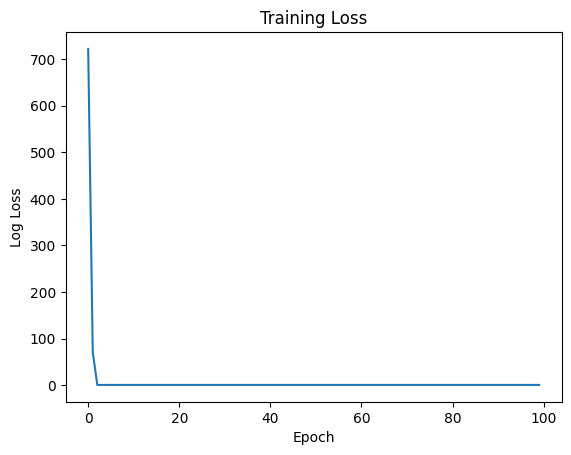

In [122]:
model = FeedforwardClassifier(1024, 256, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
num_epochs = 100

# Train the model and get loss values
loss_values = train(model, optimizer, data_loader, num_epochs)

# Plot the loss values
plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("Training Loss")
plt.show()

In [123]:
with torch.inference_mode():
    yhat = model(validation_embeddings)

Note that we've written the model to output the pre-sigmoid score. To get the actual predictions, we will have to run them through a sigmoid function

(array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 648.],
        [648.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 array([-0.434443  , -0.33907604, -0.2437091 , -0.14834215, -0.0529752 ,
         0.04239175,  0.1377587 ,  0.23312564,  0.32849258,  0.42385954,
         0.51922649]),
 <a list of 2 BarContainer objects>)

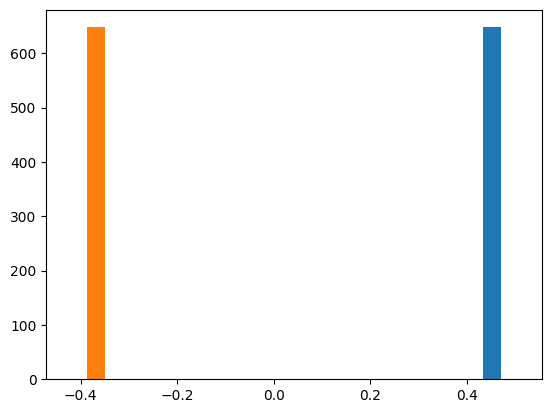

In [124]:
plt.hist(yhat)

(array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 648.],
        [648.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 array([0.3930659 , 0.41645598, 0.4398461 , 0.46323621, 0.4866263 ,
        0.51001638, 0.5334065 , 0.55679661, 0.58018672, 0.60357678,
        0.62696689]),
 <a list of 2 BarContainer objects>)

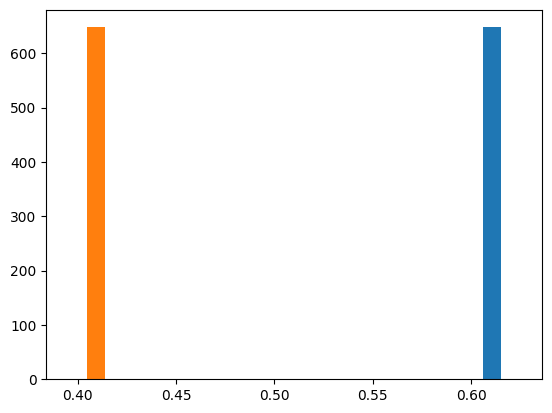

In [125]:
plt.hist(torch.sigmoid(yhat))

In [126]:
def apply_threshold(tensor, threshold):
  """
  Applies a threshold to a PyTorch tensor, changing values to 1 if above the threshold and 0 if below.

  Args:
    tensor: The input PyTorch tensor.
    threshold: The threshold value.

  Returns:
    A new tensor with values changed to 1 or 0 based on the threshold.
  """
  return (tensor > threshold).int()

In [127]:
predictions = apply_threshold(torch.sigmoid(yhat), 0.5)

In [128]:
print(torch.sum(validation_labels == predictions))
print(torch.sum(validation_labels != predictions))


tensor(1086)
tensor(210)


Plummeting fast then leveling off early suggests the learning rate may be too high. Let's check.

Epoch 1, Loss: 14.0104
Epoch 2, Loss: 2.0762
Epoch 3, Loss: 0.6907
Epoch 4, Loss: 0.6868
Epoch 5, Loss: 0.6839
Epoch 6, Loss: 0.6815
Epoch 7, Loss: 0.6795
Epoch 8, Loss: 0.6776
Epoch 9, Loss: 0.6758
Epoch 10, Loss: 0.6737
Epoch 11, Loss: 0.6687
Epoch 12, Loss: 0.6406
Epoch 13, Loss: 0.5158
Epoch 14, Loss: 0.4600
Epoch 15, Loss: 0.3979
Epoch 16, Loss: 0.3695
Epoch 17, Loss: 0.3459
Epoch 18, Loss: 0.3277
Epoch 19, Loss: 0.3089
Epoch 20, Loss: 0.2931
Epoch 21, Loss: 0.2781
Epoch 22, Loss: 0.2641
Epoch 23, Loss: 0.2511
Epoch 24, Loss: 0.2388
Epoch 25, Loss: 0.2273
Epoch 26, Loss: 0.2166
Epoch 27, Loss: 0.2066
Epoch 28, Loss: 0.1973
Epoch 29, Loss: 0.1885
Epoch 30, Loss: 0.1804
Epoch 31, Loss: 0.1728
Epoch 32, Loss: 0.1656
Epoch 33, Loss: 0.1589
Epoch 34, Loss: 0.1526
Epoch 35, Loss: 0.1467
Epoch 36, Loss: 0.1411
Epoch 37, Loss: 0.1359
Epoch 38, Loss: 0.1310
Epoch 39, Loss: 0.1265
Epoch 40, Loss: 0.1221
Epoch 41, Loss: 0.1180
Epoch 42, Loss: 0.1142
Epoch 43, Loss: 0.1106
Epoch 44, Loss: 0.1

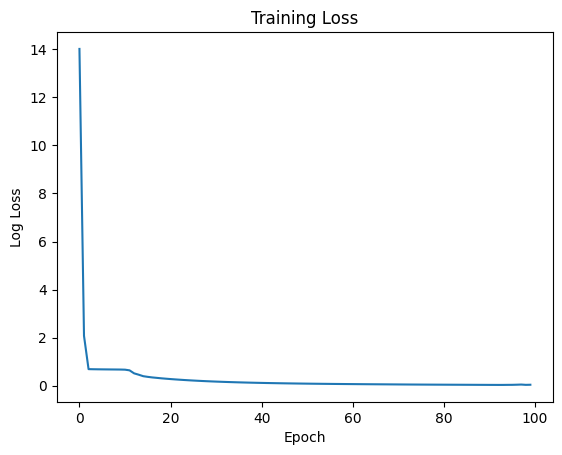

In [129]:
model = FeedforwardClassifier(1024, 256, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100

# Train the model and get loss values
loss_values = train(model, optimizer, data_loader, num_epochs)

# Plot the loss values
plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("Training Loss")
plt.show()

In [130]:
with torch.inference_mode():
    yhat = model(validation_embeddings)

In [131]:
predictions = apply_threshold(torch.sigmoid(yhat), 0.5)

In [132]:
print(torch.sum(validation_labels == predictions))
print(torch.sum(validation_labels != predictions))

tensor(870)
tensor(426)


Nope! This is definitely worse. Let's try a linear classifier instead.

In [133]:
class LinearClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, num_classes)  # First fully connected layer

    def forward(self, x):
        out = self.fc1(x)
        return out

Epoch 1, Loss: 27.1163
Epoch 2, Loss: 9.3453
Epoch 3, Loss: 4.7980
Epoch 4, Loss: 1.8438
Epoch 5, Loss: 0.5900
Epoch 6, Loss: 0.5286
Epoch 7, Loss: 0.4104
Epoch 8, Loss: 0.3444
Epoch 9, Loss: 0.2916
Epoch 10, Loss: 0.2504
Epoch 11, Loss: 0.2223
Epoch 12, Loss: 0.1973
Epoch 13, Loss: 0.1733
Epoch 14, Loss: 0.1491
Epoch 15, Loss: 0.1289
Epoch 16, Loss: 0.1116
Epoch 17, Loss: 0.0961
Epoch 18, Loss: 0.0841
Epoch 19, Loss: 0.0728
Epoch 20, Loss: 0.0624
Epoch 21, Loss: 0.0518
Epoch 22, Loss: 0.0431
Epoch 23, Loss: 0.0341
Epoch 24, Loss: 0.0316
Epoch 25, Loss: 0.0268
Epoch 26, Loss: 0.0615
Epoch 27, Loss: 0.0237
Epoch 28, Loss: 0.0638
Epoch 29, Loss: 0.0118
Epoch 30, Loss: 0.0146
Epoch 31, Loss: 0.0108
Epoch 32, Loss: 0.0280
Epoch 33, Loss: 0.0070
Epoch 34, Loss: 0.0077
Epoch 35, Loss: 0.0072
Epoch 36, Loss: 0.0203
Epoch 37, Loss: 0.0071
Epoch 38, Loss: 0.0191
Epoch 39, Loss: 0.0060
Epoch 40, Loss: 0.0143
Epoch 41, Loss: 0.0047
Epoch 42, Loss: 0.0103
Epoch 43, Loss: 0.0028
Epoch 44, Loss: 0.0

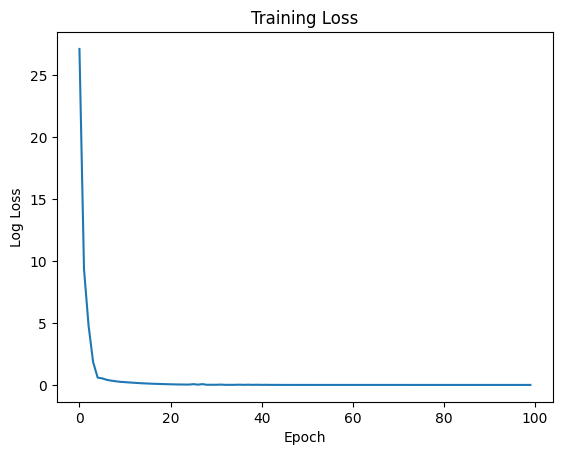

In [134]:
model = LinearClassifier(1024, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
num_epochs = 100

# Train the model and get loss values
loss_values = train(model, optimizer, data_loader, num_epochs)

# Plot the loss values
plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("Training Loss")
plt.show()

In [135]:
with torch.inference_mode():
    yhat = model(validation_embeddings)

In [119]:
predictions = apply_threshold(torch.sigmoid(yhat), 0.9)

In [ ]:
print(torch.sum(validation_labels == predictions))
print(torch.sum(validation_labels != predictions))

tensor(870)
tensor(426)


Also worse!